# This is Best Selling Phones scrapper Script and analysis

# Scrapper

In [3]:
import requests
import time
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

In [4]:
def get_all_brands_urls_dict():
    url = "https://a.pl/kategoria/smartfony-i-telefony-komorkowe-165"

    sauce = requests.get(url)
    soup = BeautifulSoup(sauce.text, 'html.parser')
    brands = {}

    for brand in soup.find('div', attrs={"data-role": "Categories"}).find('ul'):
        brands[' '.join(brand.find('a').get_text().strip().split(' '))] = 'https://a.pl' + brand.find(
            'a').get('href')
    return brands

In [5]:
def get_phones_list(page_url):
    sauce = requests.get(page_url)
    soup = BeautifulSoup(sauce.text, 'html.parser')
    all_phones = soup.find('div', attrs={"data-role":"Categories"})
    return all_phones

In [6]:
brands = get_all_brands_urls_dict()
key_list = ['LG']
phones = {}

for key in key_list:
    all_phones = get_phones_list(brands[key])
    phones[key] = {' '.join(x.text.strip().split(" ")[:-1]) : "https://www.a.pl" + x.find('a').get('href') for x in all_phones.find_all('li')}

In [9]:
def get_offer_list(phones):
    offer_list = []
    for key in phones.keys():
        for k, val in phones[key].items():
            source = requests.get(val)
            soup = BeautifulSoup(source.text, 'html.parser')
            pages_count = int(soup.find('div', attrs={"role":"navigation", "aria-label":"paginacja"}).find('span').contents[0])
            for i in range(1,pages_count+1):
                val_num = val + '?p=' + str(i)
                source_page = requests.get(val_num)
                print(key + ' ' + k + ' : '+ str(i)+"/"+str(pages_count))
                soup_page = BeautifulSoup(source_page.text, 'html.parser')
                time.sleep(0.5)
                for offer in soup_page.find_all('article', attrs = {'data-role':'offer'}):
                    url_offer = offer.find('h2').find('a').get('href')
                    cena_offer = [x.text for x in offer.find_all('span') if "zł" in x.text][0]
                    sold = [int(x.text.strip().split(" ")[0]) for x in offer.find_all('span') if "kupił" in x.text] + [0]
                    data = { 'model': k, 'url_oferty': url_offer, 'cena_oferty': cena_offer, 'sold': sold[0], 'manufacturer': key}
                    offer_list += [data]
    return offer_list


In [10]:
lista_ofert = get_offer_list(phones)
df = pd.DataFrame.from_dict(lista_ofert)

compression_opts = dict(method='zip', archive_name='out.csv')
df.to_csv('out.zip', index=False, compression=compression_opts)

LG G : 1/1
LG  : 1/1
LG G2 : 1/1
LG G3 : 1/1
LG G4 : 1/1
LG G8s : 1/1
LG K4 : 1/1
LG K8 : 1/2
LG K8 : 2/2
LG L5 II : 1/1
LG L7 II : 1/1
LG L9 II : 1/1
LG Stylus : 1/1
LG X : 1/1
LG Inne : 1/23
LG Inne : 2/23
LG Inne : 3/23
LG Inne : 4/23
LG Inne : 5/23
LG Inne : 6/23
LG Inne : 7/23
LG Inne : 8/23
LG Inne : 9/23
LG Inne : 10/23
LG Inne : 11/23
LG Inne : 12/23
LG Inne : 13/23
LG Inne : 14/23
LG Inne : 15/23
LG Inne : 16/23
LG Inne : 17/23
LG Inne : 18/23
LG Inne : 19/23
LG Inne : 20/23
LG Inne : 21/23
LG Inne : 22/23
LG Inne : 23/23


# Data Analysis 

In [11]:
df.describe()

,sold
count,1671.000000
mean,0.097546
std,0.664362
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,17.000000


In [16]:
df = pd.read_csv('out.zip')
df['offer_price_num'] = df['cena_oferty'].apply(lambda x: int(x.split(',')[0].replace(' ','')))
df['total_sale'] = df['offer_price_num'] * df['sold']
df_1 = (df.groupby('model')
     .agg(Min_price=("offer_price_num", 'min'),
          Mean_price=("offer_price_num", 'mean'),
          Max_price=('offer_price_num','max'),
          Sold=('sold', 'sum'),
          Total_Sale=('total_sale', 'sum'))
     .reset_index().round(2))
df_1.describe()

,Min_price,Mean_price,Max_price,Sold,Total_Sale
count,13.000000,13.000000,13.00000,13.000000,13.000000
mean,26.000000,329.500000,1407.00000,12.384615,10684.307692
std,24.698178,381.052082,2673.25164,40.789170,36381.779511
min,1.000000,62.710000,100.00000,0.000000,0.000000
25%,10.000000,126.800000,300.00000,0.000000,0.000000
50%,20.000000,186.870000,499.00000,0.000000,0.000000
75%,30.000000,261.620000,599.00000,2.000000,884.000000
max,99.000000,1287.000000,9999.00000,148.000000,131710.000000


In [17]:
df_1 = df_1[df_1['Total_Sale'] > 0]
df_1 = df_1[df_1['model'] != 'Inne']
df_1.sort_values(by=['Mean_price'], ascending=False, ignore_index = True)

,model,Min_price,Mean_price,Max_price,Sold,Total_Sale
0,G8s,20,1287.00,2399,2,3968
1,K8,9,194.90,499,5,1815
2,G3,30,186.87,519,1,519
3,K4,10,160.94,439,5,884


In [18]:
df_1.sort_values(by=['Total_Sale'], ascending=False, ignore_index = True)

,model,Min_price,Mean_price,Max_price,Sold,Total_Sale
0,G8s,20,1287.00,2399,2,3968
1,K8,9,194.90,499,5,1815
2,K4,10,160.94,439,5,884
3,G3,30,186.87,519,1,519


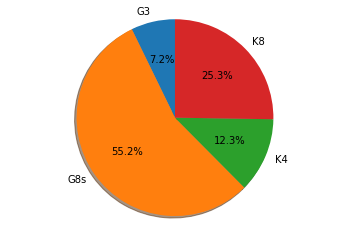

In [19]:
fig1, ax1 = plt.subplots()
ax1.pie(df_1['Total_Sale'].head(), labels=df_1['model'].head(), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()